In [2]:
# Temel
import pandas as pd
import numpy as np

# Görselleştirme
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn - ön işleme, modelleme
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
gender_sub = pd.read_csv("gender_submission.csv")

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64
Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


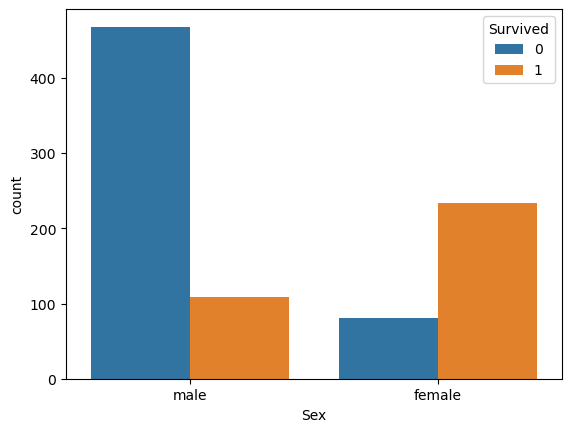

In [4]:
print(train.groupby("Sex")["Survived"].mean()) #cinsiyete göre hayatta kalma
print(train.groupby("Pclass")["Survived"].mean()) #yolcu sınıfına göre haytta kalma
#görselleştirme
sns.countplot(x="Sex", hue="Survived", data=train)
plt.show()

In [5]:
#sütün ekleme FamilySize
train["FamilySize"] = train["SibSp"] + train["Parch"] + 1
test["FamilySize"] = test["SibSp"] + train["Parch"] + 1

#sütun ekleme IsAlone
train["IsAlone"] = (train["FamilySize"] == 1).astype(int)
test["IsAlone"] = (test["FamilySize"] == 1).astype(int)

#Name'den title çıkarma
train["Title"] = train["Name"].str.extract(" ([A-Za-z]+)\.", expand=False)
test["Title"] = test["Name"].str.extract(" ([A-Za-z]+)\.", expand=False)

In [6]:
# Kullanılacak kolonlar
features = ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "IsAlone", "Title"]

X = train[features]
y = train["Survived"]
X_test = test[features]

In [8]:
#numerik ve kategorik sütunları ayır
num_features = ["Age", "Fare", "FamilySize"]
cat_features = ["Pclass", "Sex", "Embarked", "IsAlone", "Title"]

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

prepocessor = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])  

In [9]:
#basit logistic regresyon
log_reg = Pipeline([
    ("prepocessor", prepocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

log_reg.fit(X,y)

#train doğruluk
y_pred = log_reg.predict(X)
print("Accuracy:", accuracy_score(y, y_pred))
print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))

Accuracy: 0.8327721661054994
[[484  65]
 [ 84 258]]
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       549
           1       0.80      0.75      0.78       342

    accuracy                           0.83       891
   macro avg       0.83      0.82      0.82       891
weighted avg       0.83      0.83      0.83       891



In [10]:
rf = Pipeline([
    ("prepocessor", prepocessor),
    ("classifier", RandomForestClassifier(random_state=31))
])

param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [None, 5, 10],
    "classifier__min_samples_split": [2, 5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=31)

grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring="accuracy", n_jobs=-1)
grid_search.fit(X,y)

print("Best params:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)

Best params: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Best CV score: 0.8417299604544597


In [11]:
final_model = grid_search.best_estimator_

predictions = final_model.predict(X_test)

submission = pd.DataFrame({
    "PassengerId" : test["PassengerId"],
    "Survived" : predictions
})

submission.to_csv("submission.csv", index=False)
print("submission.csv oluşturuldu!")

submission.csv oluşturuldu!


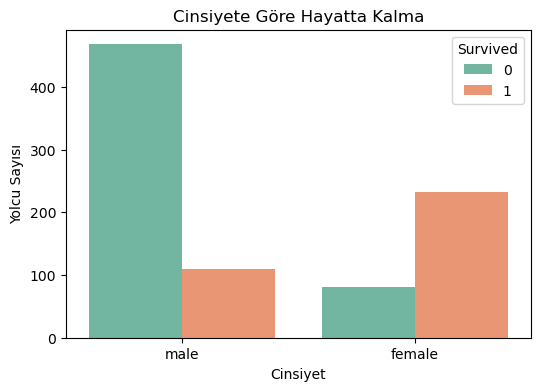

In [12]:
plt.figure(figsize=(6,4))
sns.countplot(x="Sex", hue="Survived", data=train, palette="Set2")
plt.title("Cinsiyete Göre Hayatta Kalma")
plt.xlabel("Cinsiyet")
plt.ylabel("Yolcu Sayısı")
plt.show()


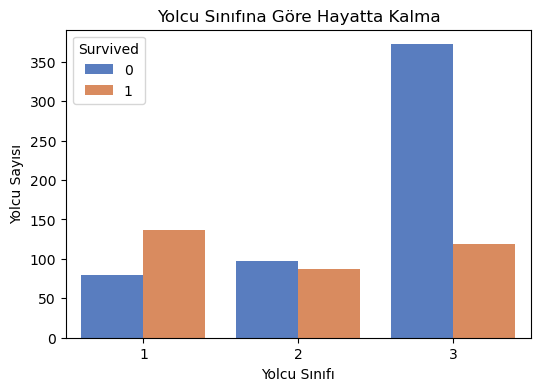

In [13]:
plt.figure(figsize=(6,4))
sns.countplot(x="Pclass", hue="Survived", data=train, palette="muted")
plt.title("Yolcu Sınıfına Göre Hayatta Kalma")
plt.xlabel("Yolcu Sınıfı")
plt.ylabel("Yolcu Sayısı")
plt.show()


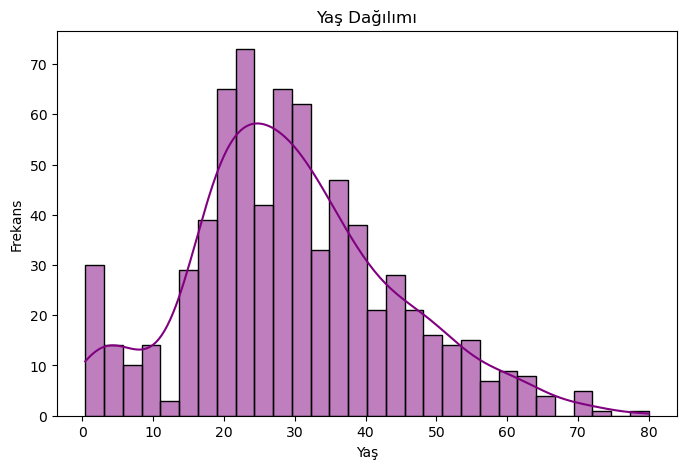

In [14]:
plt.figure(figsize=(8,5))
sns.histplot(train["Age"], bins=30, kde=True, color="purple")
plt.title("Yaş Dağılımı")
plt.xlabel("Yaş")
plt.ylabel("Frekans")
plt.show()


C:\Users\Monster\AppData\Local\Temp\ipykernel_15048\1239315814.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train.loc[train["Survived"]==1, "Age"], shade=True, label="Hayatta Kaldı")
C:\Users\Monster\AppData\Local\Temp\ipykernel_15048\1239315814.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train.loc[train["Survived"]==0, "Age"], shade=True, label="Hayatta Kalmadı")


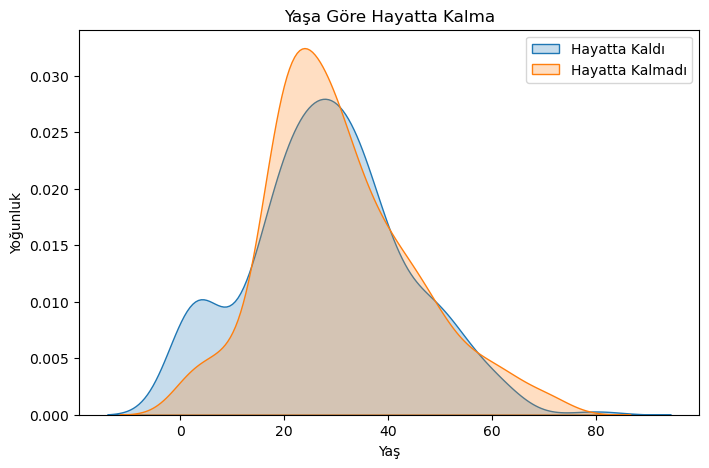

In [15]:
plt.figure(figsize=(8,5))
sns.kdeplot(train.loc[train["Survived"]==1, "Age"], shade=True, label="Hayatta Kaldı")
sns.kdeplot(train.loc[train["Survived"]==0, "Age"], shade=True, label="Hayatta Kalmadı")
plt.title("Yaşa Göre Hayatta Kalma")
plt.xlabel("Yaş")
plt.ylabel("Yoğunluk")
plt.legend()
plt.show()


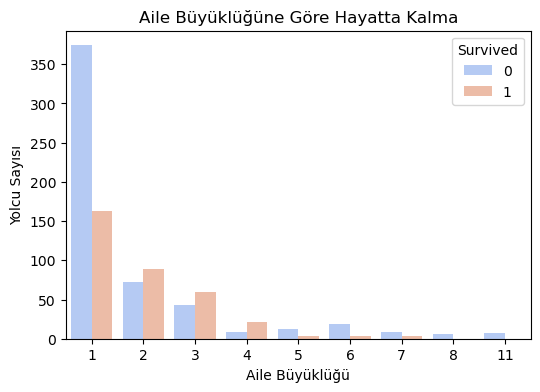

In [16]:
plt.figure(figsize=(6,4))
sns.countplot(x="FamilySize", hue="Survived", data=train, palette="coolwarm")
plt.title("Aile Büyüklüğüne Göre Hayatta Kalma")
plt.xlabel("Aile Büyüklüğü")
plt.ylabel("Yolcu Sayısı")
plt.show()


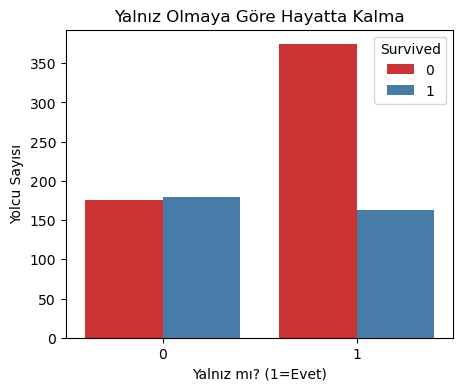

In [18]:
plt.figure(figsize=(5,4))
sns.countplot(x="IsAlone", hue="Survived", data=train, palette="Set1")
plt.title("Yalnız Olmaya Göre Hayatta Kalma")
plt.xlabel("Yalnız mı? (1=Evet)")
plt.ylabel("Yolcu Sayısı")
plt.show()


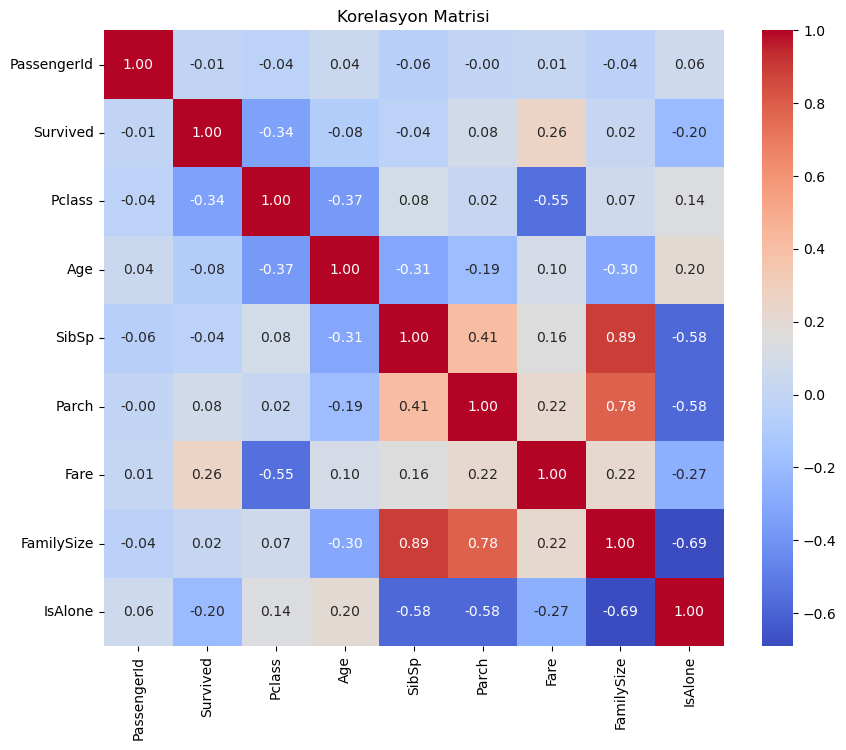

In [19]:
plt.figure(figsize=(10,8))
sns.heatmap(train.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korelasyon Matrisi")
plt.show()
